# Business Objective

To help the average investor build a portfolio of stock and ensure maximum returns. Goals of the investor could range between short-term goals like saving for a dream vacation, down payment of a home etc. to long-term goals like saving for child's education, retirement etc.

# Methodology

1. Data of the chosen stock from 2017-2022 will be scraped from [Yahoo Finance](https://finance.yahoo.com/)  using python's  `yfinance`(documentation can be found [here](https://aroussi.com/post/python-yahoo-finance)) and `YahooFinancials` (documentation can be found [here](https://pypi.org/project/yahoofinancials/)).

2. Using the data, 4 commonly used metrics to evaluate a stock will be plotted: ***returns,beta ratio,p/e ratio and dividend***

3. Using an `ARIMA` model, stock price forecasts will then be made. This is just a mathematical model and is not guaranteed success. The model cannot account for black swan events and hence the investor must use his/her discretion when choosing a stock by doing more research of the company he/she plans to invest in. 

4. Combined with stock performance and forecast information, then by feeding the chosen stock into the optimizer, the investor can look at combined returns and decide which portfolio is best-aligned with his/her goals.



# Collecting stock data and plotting metrics to evaluate performance

In [1]:
import yfinance as yf 
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from scipy.signal._signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


import logging
logging.basicConfig(level='INFO')
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

# Stock Overview

## Stock performance from 2017 till date

In [2]:
#function to get stock data of a company
start_date = '2017-01-01'
end_date = date.today()

def stock_info(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    #plot the stock price over the years
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Adj Close']);
    ax.set_title(f'Stock Price of {ticker} from 2017 till date')

## Returns from 2017 till date

In [3]:
#function to calculate stock return

def stock_return(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_return['pct_change'] = df_return['Adj Close'].pct_change() # use pct change to calculate the diff 
    df_return.drop(df_return.index[0],inplace=True) # drop the Nan value from the first row
    
    #plot the returns over 5 years
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(df_return['pct_change']);
    ax.set_title('Stock Return Pct from 2017 till date:' +' ' + ticker)


## Beta value of stock

In [4]:
#function to calculate beta value of stock

def calculate_beta(ticker):
    
    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = '2019-01-01',end = '2022-12-31')['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)
    
    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot 
    fig,ax = plt.subplots(figsize=(8,8));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value = {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker} value')

## P/E ratios from 2017 till date

In [5]:

#function to get historical PE ratios

def get_pe_ratio(ticker):
    
    #get financial statement of ticker using yahoofinancials
    financials = YahooFinancials(ticker)
    statement = financials.get_financial_stmts('annual', 'income', reformat=True)    
    
    #create a dict of the income statement alone
    dicts ={}
    for i in statement['incomeStatementHistory'][ticker]:
        dicts.update(i)
    
    #create a dataframe for easy use
    df = pd.DataFrame(dicts)
    df = df.T
    df['dilutedAverageShares'].fillna(df['dilutedAverageShares'].median(),inplace=True)
    
    #calculate pe ratio
    eps = df['netIncomeContinuousOperations']/df['dilutedAverageShares'] #calc earnings per share
    eps_df = pd.DataFrame(eps,index=df.index,columns=['EPS'])
    eps_df['PE ratio'] = financials.get_current_price()/eps_df['EPS']#get current price and calc pe ratio
    
    #plot result
    fig,ax=plt.subplots(figsize=(8,8));
    ax.plot(eps_df['PE ratio'],marker = '*', markerfacecolor = 'black')
    ax.set_title(f'Historical PE ratio: {ticker}')
    ax.set_ylabel('PE ratio')

## Dividend History from 2017 till date

In [6]:
#function to get historical dividend data

def get_dividend(ticker):
    
    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data(start_date=start_date,end_date='2022-12-31')
    
    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')
        return fig,ax
    
    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(8,8))
        ax.plot(df['amount']);
        ax.set_title(f'Dividend rate: {ticker}');

# Summing up performance...

In [7]:
def summary_info(ticker):
    return stock_info(ticker),stock_return(ticker),calculate_beta(ticker),get_pe_ratio(ticker),get_dividend(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


(None, None, None, None, None)

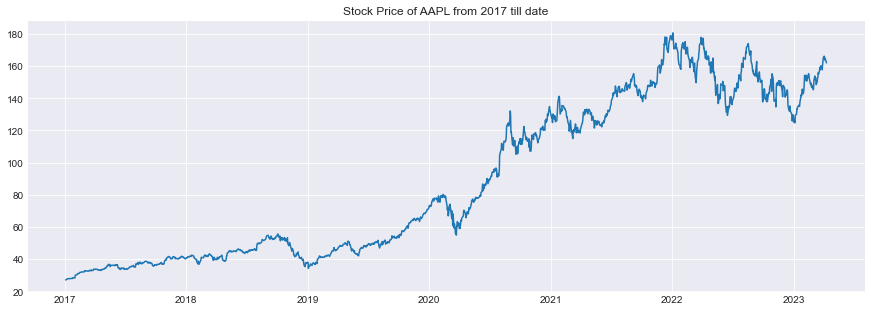

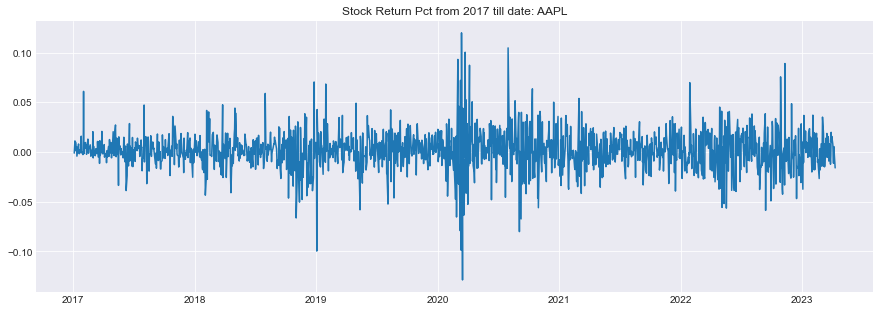

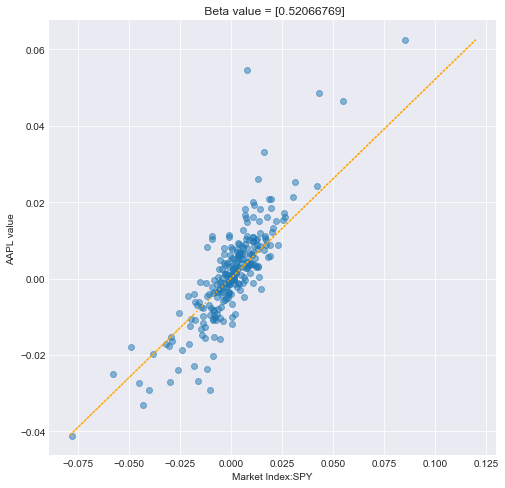

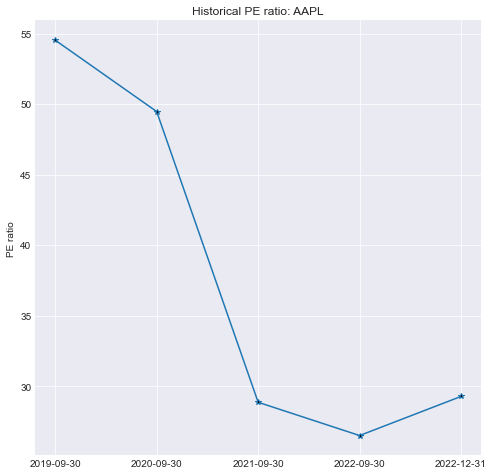

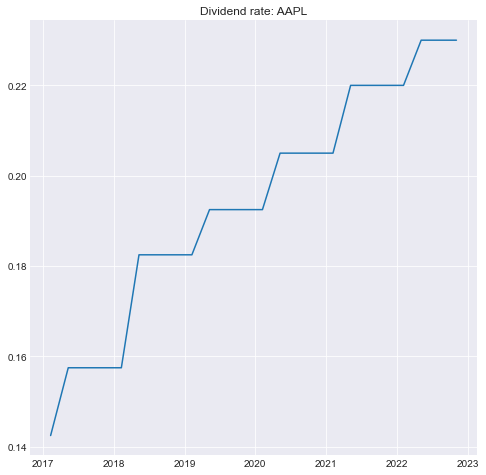

In [8]:
summary_info('AAPL')

# Time Series Modelling

For building a model, we will use data of Apple(tickr:'AAPL') as an example. 

## Stationarity Check

In [9]:
def plot_trends(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    close = df.loc[:,['Adj Close']]

#compute rolling mean and std to see if they are constant
    roll_mean = close.rolling(window=30,center=False).mean()
    roll_std = close.rolling(window=30,center=False).std()

#plot the data
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(close,color='blue',label='Original')
    ax.plot(roll_mean,color='red',label='Rolling Mean')
    ax.plot(roll_std,color='green',label='Rolling StdDev')
    ax.legend(loc='best')
    ax.set_title(f'Rolling Statistics of {ticker}');

#dickey Fuller Test
    dftest = adfuller(close['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

## Convert non-stationary to stationary 

In [10]:
def differencing(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_diff =df_return.diff(periods=1)
    df_diff.dropna(inplace=True)
    
    #plot the results
    fig,ax = plt.subplots(figsize = (12,8));
    ax.plot(df_diff, label = 'Differenced');
    ax.plot(df_diff.rolling(30).mean(),label = 'Rolling Mean')
    ax.plot(df_diff.rolling(30).std(),label = 'Rolling StdDev')
    ax.set_title(f'Differenced plot of {ticker}')
    ax.legend(loc=2);
    
    #dickey fuller test
    dftest = adfuller(df_diff['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

##  ACF and PACF

[*********************100%***********************]  1 of 1 completed


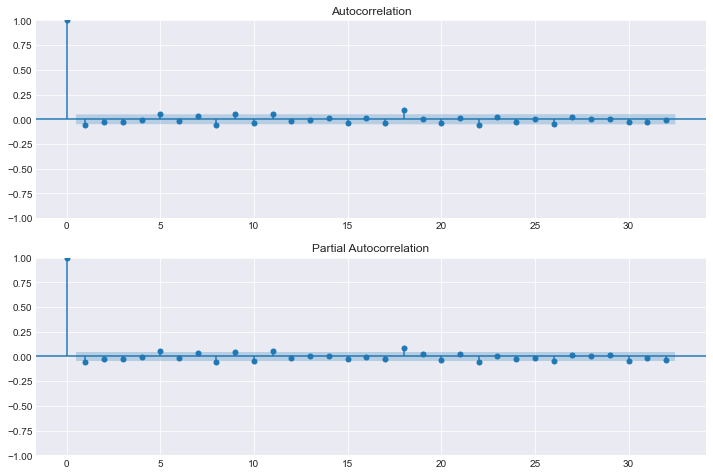

In [11]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]
df_diff =df_close.diff(periods=1)
df_diff.dropna(inplace=True)

#plot ACF and PACF values
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,8))
acf = plot_acf(df_diff,ax=ax1)
pacf = plot_pacf(df_diff,ax=ax2)

## ARIMA model

In [12]:
#defining train and test sets
cutoff= int(df_close.shape[0]*0.75)
train = df_close[:cutoff]
test = df_close[cutoff:]

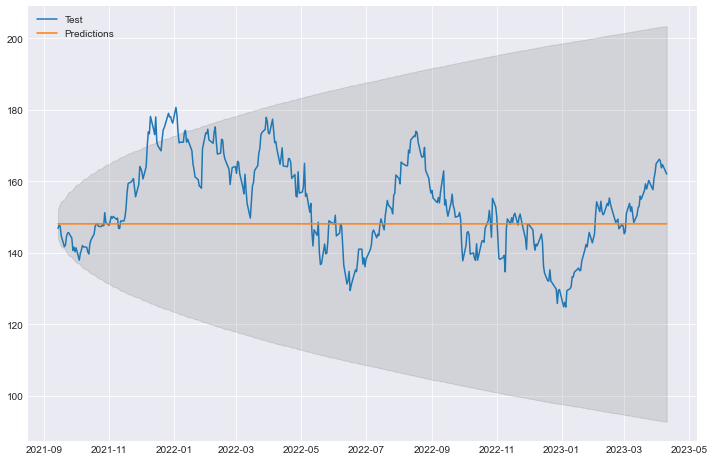

In [13]:
# (1,1,1) ARIMA(p,d,q) based on ACF and PACF plots
#instantiate
model = ARIMA(train,order=(1,1,1))

#fit
model_fit = model.fit()
# print(model_fit.summary())

#getting predictions using get_prediction method
arima_predictions = model_fit.get_prediction(start = len(train)+1 , end = len(df_close),dynamic=True)
#predicted_mean gives lists the values
arima_pred_price=arima_predictions.predicted_mean
#converting into a df
arima_pred_price_df = pd.DataFrame(data=arima_pred_price)
#seetting the index to the test dates
arima_pred_price_df.index= test.index

# arima_pred_price_df.head()

#confidence intervals of predictions
arima_conf_int = arima_predictions.conf_int()
arima_conf_int.set_index(test.index,inplace=True)

# arima_conf_int.head()

#plotting predictions with confidence intervals
fig,ax =plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(arima_pred_price_df,label='Predictions');
# ax.plot(arima_conf_int,label='Confidence Intervals')
ax.fill_between(arima_conf_int.index,arima_conf_int.iloc[:,0],arima_conf_int.iloc[:,1],color='k',alpha=0.1);
ax.legend(loc=2);

In [14]:
#RMSE
error_arima = round(np.sqrt(mean_squared_error(test,arima_pred_price_df)),2)
print(f'RMSE of the model is {error_arima}')

RMSE of the model is 13.61


## SARIMA model

In [15]:
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(train,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('SARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

SARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=13605.938017357566
SARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=11979.290007370098
SARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=7082.9838017812
SARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=7003.371344154519
SARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=7004.634116759415
SARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=6998.842194582676
SARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=7010.869539990012
SARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=7004.746962755439
SARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=12005.957953839796
SARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=10428.391274746278
SARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=6131.357997772469
SARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=6080.46549023323
SARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=6085.343494245377
SARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=6067.750913803244
SARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=6089.8128524

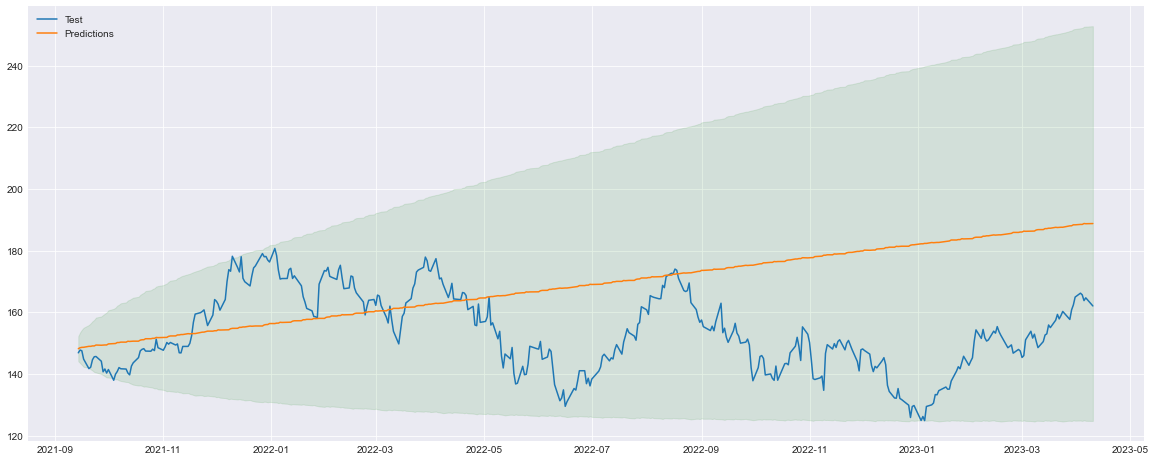

In [17]:
# Plug the optimal parameter values into a new SARIMAX model
sarimax = SARIMAX(train, 
                  order=(1,1,1), 
                  seasonal_order=(0 ,1, 1, 12), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

# Fit the model and print results
output = sarimax.fit()

#get predictions
sarimax_predictions = output.get_prediction(start=len(train)+1,end=len(df_close),dynamic=True)
sarimax_price=sarimax_predictions.predicted_mean
sarimax_predictions_df = pd.DataFrame(data=sarimax_price)
sarimax_predictions_df.index= test.index

#get confidence intervals
sarimax_conf_int = sarimax_predictions.conf_int()
sarimax_conf_int.set_index(test.index,inplace=True)

#plot results
fig,ax =plt.subplots(figsize=(20,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(sarimax_predictions_df,label='Predictions');
# ax.plot(sarimax_conf_int,label='Confidence Intervals')
ax.fill_between(sarimax_conf_int.index,sarimax_conf_int.iloc[:,0],sarimax_conf_int.iloc[:,1],color='g',alpha=0.1);
ax.legend(loc=2);

In [18]:
#RMSE
error_sarima = round(np.sqrt(mean_squared_error(test,sarimax_predictions_df)),2)
print(f'RMSE of the model is {error_sarima}')

RMSE of the model is 24.96


## Facebook Prophet

[*********************100%***********************]  1 of 1 completed
RMSE of the model is 27.94


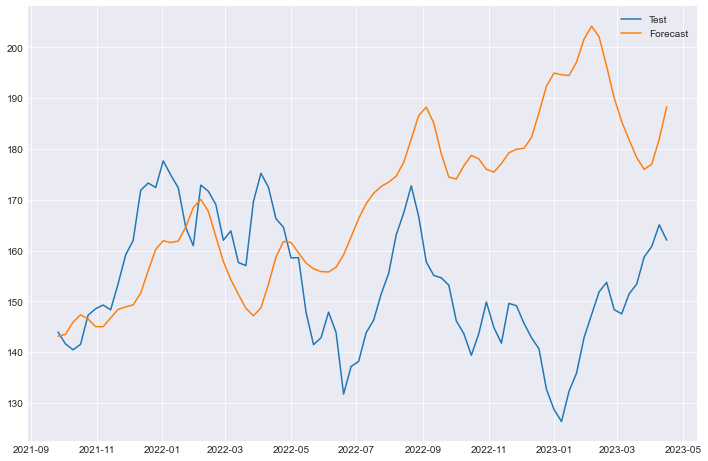

In [19]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

#setting up df to be able to run Prophet

#reset index
df_weekly.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#set the date as the index
# df_close.set_index('ds',inplace=True)
# df_weekly.head()

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

#RMSE
error_fb = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is {error_fb}')

In [20]:
#run a loop for different regularization values

seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
new_error_fb = None

for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)
        
        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

        #predicting yhat 
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']]
        
        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        new_error_fb = min(errors)
        print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')
        
print('----------------------------------------------')
print(f'Smallest RMSE after looping is {new_error_fb}')
print(f'Original RMSE is {error_fb}')

seasonality_scale:0.1, changepoint_scale:0.1, rmse:30.354
seasonality_scale:0.1, changepoint_scale:0.2, rmse:28.759
seasonality_scale:0.1, changepoint_scale:0.3, rmse:27.492
seasonality_scale:0.1, changepoint_scale:0.4, rmse:26.782
seasonality_scale:0.1, changepoint_scale:0.5, rmse:26.229
seasonality_scale:0.2, changepoint_scale:0.1, rmse:28.889
seasonality_scale:0.2, changepoint_scale:0.2, rmse:26.838
seasonality_scale:0.2, changepoint_scale:0.3, rmse:25.937
seasonality_scale:0.2, changepoint_scale:0.4, rmse:25.535
seasonality_scale:0.2, changepoint_scale:0.5, rmse:24.932
seasonality_scale:0.3, changepoint_scale:0.1, rmse:28.293
seasonality_scale:0.3, changepoint_scale:0.2, rmse:26.273
seasonality_scale:0.3, changepoint_scale:0.3, rmse:25.325
seasonality_scale:0.3, changepoint_scale:0.4, rmse:25.115
seasonality_scale:0.3, changepoint_scale:0.5, rmse:24.6
seasonality_scale:0.4, changepoint_scale:0.1, rmse:27.318
seasonality_scale:0.4, changepoint_scale:0.2, rmse:25.137
seasonality_scal

### Prophet with differencing - comparing with test

[*********************100%***********************]  1 of 1 completed
RMSE of the model is 6.08


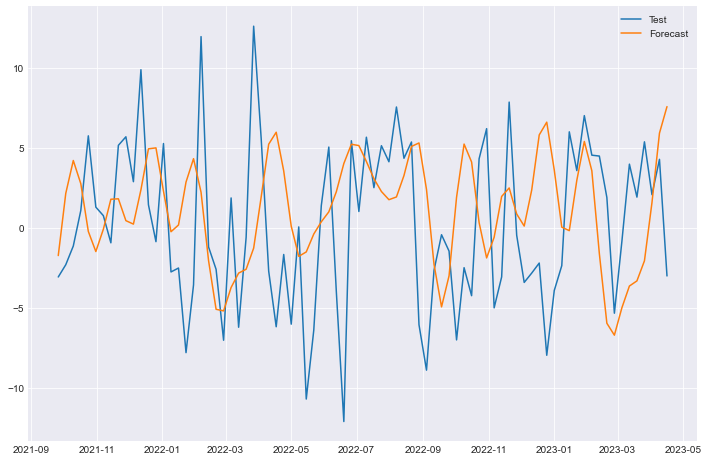

In [21]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly = df_weekly.diff(periods=1)
df_weekly.dropna(inplace=True)

#setting up df to be able to run Prophet
#reset index
df_weekly.reset_index(inplace=True)
#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

error_fb_diff = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is {error_fb_diff}')

### regularization on differenced data

In [ ]:
#run a loop for different regularization values
seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
new_error_fb_diff = None

for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)
        
        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=len(test),freq='W',include_history=False)

        #predicting yhat 
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']]
        
        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        new_error_fb_diff = min(errors)
        print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')
        
print('----------------------------------------------')
print(f'Smallest RMSE after looping is {new_error_fb_diff}')
print(f'Original RMSE is {error_fb_diff}')

seasonality_scale:0.1, changepoint_scale:0.1, rmse:5.991
seasonality_scale:0.1, changepoint_scale:0.2, rmse:6.035
seasonality_scale:0.1, changepoint_scale:0.3, rmse:6.156
seasonality_scale:0.1, changepoint_scale:0.4, rmse:6.285


## Model performance comparisions

In [ ]:
fig,ax =plt.subplots(figsize=(10,7))
ax.bar(x=['ARIMA', 'SARIMAX', 'PROPHET','PROPHET_diff'],height=[error_arima,error_sarima,new_error_fb,new_error_fb_diff]);
ax.set_title('RMSE score comparision');


## Using Prophet to get forecast of 'AAPL"

In [ ]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly_diff = df_weekly.diff(periods=1)
df_weekly_diff.dropna(inplace=True)


#setting up df to be able to run Prophet

#reset index
df_weekly_diff.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly_diff.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)


#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
            seasonality_prior_scale = 0.4,
            changepoint_prior_scale = 0.3
           )

#fit
m.fit(df_weekly_diff)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']]

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
df_weekly_diff.set_index('ds',inplace=True)


#taking the inverse difference of the predicted values to get the original values
# the inverse diff is the cumsum of the first value of the org series & the first differences series
forecast_values.rename(columns={'yhat':'y'},inplace=True)
invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(df_weekly,label='Current Price')
ax.plot(invdiff_df['y'],label='Forecast')
ax.legend();

# Predictions of chosen stock

In [ ]:
def forecast_price(ticker):
    #get stock data
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]

    #resmapling by weekly
    df_weekly = df_close.resample('W').mean()
    df_weekly_diff = df_weekly.diff(periods=1)
    df_weekly_diff.dropna(inplace=True)


    #setting up df to be able to run Prophet
    #reset index
    df_weekly_diff.reset_index(inplace=True)
    #rename columns per prophet conventions
    df_weekly_diff.rename(columns={'Adj Close': 'y',
                             'Date':'ds'},inplace=True)


    #instantiate
    m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90, 
                seasonality_prior_scale = 0.4,
                changepoint_prior_scale = 0.3
               )

    #fit
    m.fit(df_weekly_diff)

    #forecasts - creating future dates using in built make_future_dataframe method
    future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

    #predicting yhat 
    forecast = m.predict(future)

    #creating a df of predicted values
    forecast_values = forecast[['ds', 'yhat']]

    #set the index for the plots
    forecast_values.set_index('ds',inplace=True)
    df_weekly_diff.set_index('ds',inplace=True)


    #taking the inverse difference of the predicted values to get the original values
    # the inverse diff is the cumsum of the first value of the org series & the first differences series
    forecast_values.rename(columns={'yhat':'y'},inplace=True)
    invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
    invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])

    #plotting results
    fig,ax=plt.subplots(figsize=(12,8))
    ax.plot(df_weekly,label='Current Price')
    ax.plot(invdiff_df['y'],label='Forecast')
    ax.set_title(f'Predicted values of {ticker}')
    ax.legend();

# Building Portfolio

In [ ]:
def get_current_price(ticker):
    df = yf.download(ticker,start=date.today())
    ticker_df = df[['Adj Close']]
    current_price = round(float(ticker_df.iloc[0]),2)
    
    return current_price

In [ ]:
def get_latest_price(ticker):
     #get stock data
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]

    #resmapling by weekly
    df_weekly = df_close.resample('W').mean()
    df_weekly_diff = df_weekly.diff(periods=1)
    df_weekly_diff.dropna(inplace=True)


    #setting up df to be able to run Prophet
    #reset index
    df_weekly_diff.reset_index(inplace=True)
    #rename columns per prophet conventions
    df_weekly_diff.rename(columns={'Adj Close': 'y',
                             'Date':'ds'},inplace=True)


    #instantiate
    m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90, 
                seasonality_prior_scale = 0.4,
                changepoint_prior_scale = 0.3
               )

    #fit
    m.fit(df_weekly_diff)

    #forecasts - creating future dates using in built make_future_dataframe method
    future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

    #predicting yhat 
    forecast = m.predict(future)

    #creating a df of predicted values
    forecast_values = forecast[['ds', 'yhat']]

    #set the index for the plots
    forecast_values.set_index('ds',inplace=True)
    df_weekly_diff.set_index('ds',inplace=True)

    #taking the inverse difference of the predicted values to get the original values
    # the inverse diff is the cumsum of the first value of the org series & the first differences series
    forecast_values.rename(columns={'yhat':'y'},inplace=True)
    invdiff = np.r_[df_weekly['Adj Close'].iloc[-1],forecast_values['y'][1:]].cumsum()
    invdiff_df = pd.DataFrame(data=invdiff,index = forecast_values.index,columns=['y'])
    
    #get the last value
    last_price = round(float(invdiff_df.iloc[-1]),2)
    
    return last_price

In [ ]:
# def portfolio(amount,stocks):
#     amount = amount
#     stocks = stocks
#     percents = np.arange(0.05,1,0.05)
#     returns = []
#     invest_amount = []
    
#     stock1_current_price = get_current_price(stocks[0])
#     stock2_current_price = get_current_price(stocks[1])
    
#     stock1_sell_price = get_latest_price(stocks[0])
#     stock2_sell_price = get_latest_price(stocks[1])
    
#     for i in percents:
#         stock1_invest_amount = round(i*1000)
#         stock2_invest_amount = amount - stock1_invest_amount
#         invest_amount.append((stock1_invest_amount,stock2_invest_amount))
        
        
#         if (stock1_invest_amount > stock1_current_price) & (stock2_invest_amount > stock2_current_price):
#             stock1_shares = round(stock1_invest_amount/stock1_current_price,1)
#             stock2_shares = round(stock2_invest_amount/stock2_current_price,1)

            
#             stock1_aftersale_amount = round(stock1_shares*stock1_sell_price,2)
#             stock2_aftersale_amount = round(stock2_shares*stock2_sell_price,2)
            
#             stock1_return = round(stock1_aftersale_amount/stock1_invest_amount - 1,3)
#             stock2_return = round(stock2_aftersale_amount/stock2_invest_amount - 1,3)
            
#             stock1_prop = stock1_invest_amount/amount
#             stock2_prop = stock2_invest_amount/amount
            
#             portfolio_return = round((stock1_prop*stock1_return) + (stock2_prop*stock2_return),4)
#             portfolio_return_pct = round(portfolio_return*100,2)
#             returns.append(portfolio_return_pct)
            
            
#             print(f'investments:{stocks[0]}: ${stock1_invest_amount}, {stocks[1]}: ${stock2_invest_amount}')
#             print(f'total returns: {portfolio_return_pct}%')
#             print('\n')
            
#         else:
#             print(f'${stock1_invest_amount},${stock2_invest_amount} will not work since the price of 1 share is more than the invested amount')
#             print('\n')
            
#     returns = pd.Series(returns)
#     invest = pd.Series(invest_amount)
            
#     df = pd.concat([invest,returns],axis=1)
#     df.rename(columns={0:'invest_amount',1:'returns'},inplace=True)
#     return df
# #     fig,ax=plt.subplots(figsize=(12,8))
# #     ax.plot(df['returns'])
# #     ax.set_xticklabels(df['invest_amount'])
            
# #     fig,ax=plt.subplots(figsize=(12,8))
# #     ax.plot(returns);
# #     ax.set_xticklabels(invest_amount);
# #     ax.set_title(f'Total Returns: {stocks[0], stocks[1]}',{'fontsize':18});
# #     ax.set_xlabel('Combination Amounts in $',{'fontsize':14})
# #     ax.set_ylabel('Returns %',{'fontsize':14})

    
    

In [ ]:
portfolio(1000,['AAPL','AMZN'])